# Neural network architectures: Uniaxial Compression


### See following publication for details:
Mital, U., Andrade, J.E. Bridging length scales in granular materials using convolutional neural networks. Comp. Part. Mech. (2021). https://doi.org/10.1007/s40571-021-00405-1

**Note:** Due to inherent stochasticity, mean absolute errors of the models are not exactly the same as those reported in the manuscript. But they are similar.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os, glob
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras import backend as K
K.set_image_data_format('channels_last')
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set(font_scale=1.35, style='white')

Using TensorFlow backend.


## Read the data: Uniaxial compression (Can ignore the next cell)

Experimental data (not provided) is obtained from the following publication:

Marteau, E., Andrade, J.E. A novel experimental device for investigating the multiscale behavior of granular materials under shear. Granular Matter 19, 77 (2017). https://doi.org/10.1007/s10035-017-0766-x

X_data is arranged as follows (number_of_timesteps, number_of_contacts, number_of_channels) <br>
Channel_0: Contact forces $f_y$ (kN/m) <br>
Channel_1: Branch vectors $d_y$ (cm)

Y_data is Load $F_N$ (N): <br>
Load curve shown in Figure 4 of Mital and Andrade (2021).


**Note: In what follows, num_pixels refers to number_of_contacts**

In [2]:
########## Some script to read experimental data (can ignore) ###############
os.chdir('data_regression/')
path = os.getcwd()
count = 0
data = []    
for infile in glob.glob( os.path.join(path, '*.dat') ):
    data.append(np.loadtxt(infile))
    count += 1
os.chdir('..')
data = np.asarray(data)
timesteps = data[:,-1,1] 
sorted_indices = np.argsort(timesteps)
time = timesteps[sorted_indices]
X_data = data[sorted_indices,0:-1] 
y_data = -data[sorted_indices,-1,0] 
###################################################################################

X_data_forces = X_data[:,:,0] # Select the first "channel" which is Contact forces. No branch vectors

num_timesteps = X_data.shape[0] # 16
num_pixels = X_data.shape[1] # 725; refers to number_of_contacts
num_channels = X_data.shape[2] # 2

In [3]:
X_data.shape

(16, 725, 2)

In [4]:
X_data_forces.shape

(16, 725)

In [5]:
y_data.shape

(16,)

## Experiment 1: MLP architecture


In [35]:
def MLP_model():
    # create model
    model = Sequential()
    model.add(Dense(num_pixels, input_dim=num_pixels, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [8]:
model = MLP_model()

# Split data into training and test
X_train, X_test, y_train, y_test, time_train, time_test = train_test_split(X_data_forces, y_data, time, test_size=0.5, random_state=50)

# Fit the model
model.fit(X_train, y_train, epochs=100, batch_size=2, verbose=0)

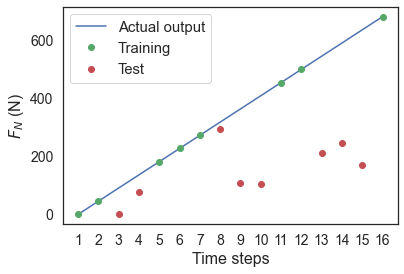

In [9]:
plt.plot(time, y_data,'-',label='Actual output')
plt.plot(time_train, model.predict([X_train]),'go',label='Training')
plt.plot(time_test, model.predict([X_test]),'ro',label='Test')
plt.legend(loc=2)
plt.xlabel('Time steps',fontsize=16)
plt.ylabel('$F_N$ (N)',fontsize=16)
plt.xticks(time,fontsize=14)

plt.yticks(fontsize=14)
plt.show()

### Mean absolute error (training)

In [10]:
np.mean(np.abs(model.predict([X_train])[:,0] - y_train))

0.0006600176915574352

### Mean absolute error (testing)

In [11]:
np.mean(np.abs(model.predict([X_test])[:,0] - y_test))

234.67441792190073

## Experiment 2: Convolutional neural net architecture

In [38]:
def CNN_model_Exp2():
    # create model
    model = Sequential()
    model.add(Conv2D(32, (5, 1), input_shape=(num_pixels, 1,  1), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 1)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [14]:
model = CNN_model_Exp2()

#### Reshaping the data for the CNN architecture

In [15]:
X_new = X_data_forces.reshape(X_data_forces.shape[0], num_pixels, 1, 1)

In [16]:
X_new.shape

(16, 725, 1, 1)

In [17]:
model = CNN_model_Exp2()
# Split data into training and test
X_train, X_test, y_train, y_test, time_train, time_test = train_test_split(X_new, y_data, time, test_size=0.5,random_state=50)
model.fit(X_train, y_train, epochs=100, batch_size=2, verbose=0)

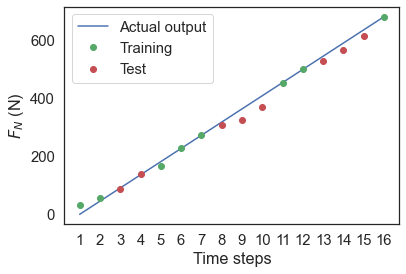

In [18]:
plt.plot(time, y_data,'-',label='Actual output')
plt.plot(time_train, model.predict([X_train]),'go',label='Training')
plt.plot(time_test, model.predict([X_test]),'ro',label='Test')
plt.legend(loc=2)
plt.xlabel('Time steps')
plt.ylabel('$F_N$ (N)')
plt.xticks(time)
plt.show()

### Mean absolute error (training)

In [19]:
np.mean(np.abs(model.predict([X_train])[:,0] - y_train))

7.576075839996343

### Mean absolute error (testing)

In [20]:
np.mean(np.abs(model.predict([X_test])[:,0] - y_test))

19.160479164123544

## Experiment 3: Shallow CNN architecture

In [40]:
def CNN_model_Exp3_shallow():
    # create model
    model = Sequential()
    model.add(Conv2D(32, (5, 1), input_shape=(num_pixels, 1, 2), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 1)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [23]:
X_data_reshaped = X_data.reshape(X_data.shape[0], num_pixels, 1, 2)

In [24]:
# Split data into training and test
model = CNN_model_Exp3_shallow()

X_train, X_test, y_train, y_test, time_train, time_test = (
    train_test_split(X_data_reshaped, y_data, time, test_size=0.5,random_state=50))
model.fit(X_train, y_train, epochs=100, batch_size=2, verbose=0)

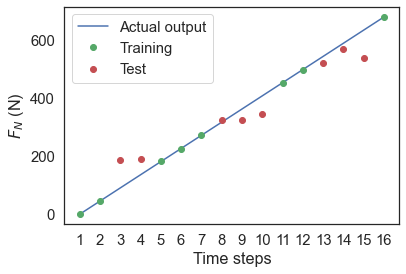

In [25]:
plt.plot(time, y_data,'-',label='Actual output')
plt.plot(time_train, model.predict([X_train]),'go',label='Training')
plt.plot(time_test, model.predict([X_test]),'ro',label='Test')
plt.legend(loc=2)
plt.xlabel('Time steps')
plt.ylabel('$F_N$ (N)')
plt.xticks(time)
# plt.savefig('Regression1D_twochannel_singleCNN.png', dpi=300, bbox_inches='tight')
plt.show()

### Mean absolute error (training)

In [26]:
np.mean(np.abs(model.predict([X_train])[:,0] - y_train))

0.8083751074969721

### Mean absolute error (testing)

In [27]:
np.mean(np.abs(model.predict([X_test])[:,0] - y_test))

49.66875381469727

## Experiment 3: Deep CNN architecture

In [43]:
def CNN_model_Exp3_deep():
    # create model
    model = Sequential()
    model.add(Conv2D(32, (5, 1), input_shape=(num_pixels, 1, 2), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 1)))
    model.add(Conv2D(64, (5, 1), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 1)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [76]:
# Split data into training and test
model = CNN_model_Exp3_deep()

X_train, X_test, y_train, y_test, time_train, time_test = (
    train_test_split(X_data_reshaped, y_data, time, test_size=0.5, random_state=50))
# np.random.seed(50)  ## setting seeds doesn't quite work. Some randomness is still there. 
model.fit(X_train, y_train, epochs=100, batch_size=2, verbose=0)
train_score = model.evaluate(X_train, y_train, verbose=2)
test_score = model.evaluate(X_test, y_test, verbose=2)
print (train_score, test_score)

17.099056243896484 1144.9903564453125


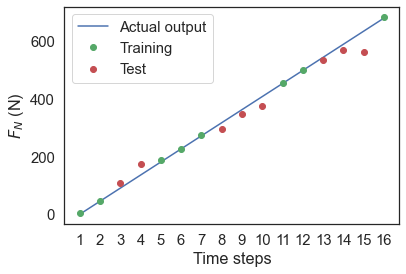

In [77]:
plt.plot(time, y_data,'-',label='Actual output')
plt.plot(time_train, model.predict([X_train]),'go',label='Training')
plt.plot(time_test, model.predict([X_test]),'ro',label='Test')
plt.legend(loc=2)
plt.xlabel('Time steps')
plt.ylabel('$F_N$ (N)')
plt.xticks(time)
plt.show()

### Mean absolute error (training)

In [78]:
np.mean(np.abs(model.predict([X_train])[:,0] - y_train))

3.389759027957923

### Mean absolute error (testing)

In [79]:
np.mean(np.abs(model.predict([X_test])[:,0] - y_test))

28.205345535278326

## Print model architectures

In [34]:
K.clear_session()

In [36]:
MLP_model().summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 725)               526350    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 726       
Total params: 527,076
Trainable params: 527,076
Non-trainable params: 0
_________________________________________________________________


In [39]:
CNN_model_Exp2().summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 721, 1, 32)        192       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 360, 1, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 360, 1, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 11520)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               1474688   
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 129       
Total params: 1,475,009
Trainable params: 1,475,009
Non-trainable params: 0
____________________________________________

In [42]:
CNN_model_Exp3_shallow().summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 721, 1, 32)        352       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 360, 1, 32)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 360, 1, 32)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 11520)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               1474688   
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 129       
Total params: 1,475,169
Trainable params: 1,475,169
Non-trainable params: 0
____________________________________________

In [44]:
CNN_model_Exp3_deep().summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 721, 1, 32)        352       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 360, 1, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 356, 1, 64)        10304     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 178, 1, 64)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 178, 1, 64)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 11392)             0         
_________________________________________________________________
dense_7 (Dense)              (None, 128)              